# Training the electric network

Write a two-layer neural network to train image in raw format. The network is trained to predict the electric network from the image. The network is trained on the training set and evaluated on the test set. The network is trained using stochastic gradient descent with a fixed learning rate and no regularization.

In [1]:
# import the necessary packages
import torch as torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# import raw image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## 1. have a feel of the raw image

[[10467 12525 13927 ...  7098  7706  7925]
 [12844 13906  9647 ...  6527  6522  6164]
 [13717 12368  6016 ...  7291  7276  6490]
 ...
 [ 7560  4947  4667 ...  7730  7484  5078]
 [ 8558  5854  6281 ...  8016  7724  5039]
 [ 7936  6199  7346 ...  7341  6705  4643]]


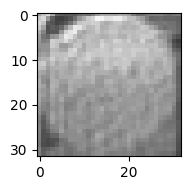

In [12]:
# open the raw image file
with open('test_image/pic_20231025_15 1 2_991.raw', 'rb') as f:
    # read the raw image data
    raw_data = f.read()

# create a PIL image from the raw data
width, height = 32, 32
img = Image.frombytes('I;16', (width, height), raw_data, decoder_name='raw')
# img.show()

# convert the PIL image to a numpy array
image = np.array(img)
print(image)

# display the image
plt.figure(figsize=(2,2))
plt.imshow(image, cmap='gray', vmin=0, vmax=2**14-1)
plt.tight_layout()

## 2. make a dataset
3 kinds of objects in 3 folders, 250 raw images in each folder, labeled as 0, 1, 2.

`datasets.ImageFolder(root='./data', transform=transform)` do not support raw image, so we need to make a dataset by ourselves.

In [ ]:

# define the path to the root folder of the dataset
root = '红外光测试'

# define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((1, 32*32)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

# create the Image dataset with only raw images
dataset = datasets.ImageFolder(root=root, transform=transform, )

# print the class labels
print('dataset.class:', dataset.classes)

# add label to images in each folder
dataset.class_to_idx = {'img32x32_20231023_113512_flight': 0, 
                        'img32x32_20231023_113737_oil': 1, 
                        'img32x32_20231023_113921_boat': 2}

# print an example in dataset
print(dataset[1], '\n', 
    dataset[1][0].shape, '\n',
    dataset[1][1])


# print the number of images in the dataset
print(len(dataset))

# # print the number of images per class
# print(dataset.class_counts)
training_data = DataLoader(dataset, batch_size=25, shuffle=True)
train_dataloader = DataLoader(training_data, batch_size=25)

### import dataset

In [ ]:

# define the path to the root folder of the dataset
root = '红外光测试'

# define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((1, 32*32)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

# create the Image dataset with only raw images
dataset = datasets.ImageFolder(root=root, transform=transform, )

# print the class labels
print('dataset.class:', dataset.classes)

# add label to images in each folder
dataset.class_to_idx = {'img32x32_20231023_113512_flight': 0, 
                        'img32x32_20231023_113737_oil': 1, 
                        'img32x32_20231023_113921_boat': 2}

# print an example in dataset
print(dataset[1], '\n', 
    dataset[1][0].shape, '\n',
    dataset[1][1])


# print the number of images in the dataset
print(len(dataset))

# # print the number of images per class
# print(dataset.class_counts)
training_data = DataLoader(dataset, batch_size=25, shuffle=True)
train_dataloader = DataLoader(training_data, batch_size=25)

## 3. define the network

The input tensor is a 32 * 32 raw image and flatten to 1 * 1024.

The weight value in the 1st layer should be binary (+1 or -1), the dimension of the weight matrix is 1024*32. The activation function is relu function.

The weight value in the 2nd layer signed 16 bit, the dimension of the weight matrix is 32 *3. The output is 1 *3 matrix. The activation function is softmax function.

In [4]:
# define the network
# The weight value in the 1st layer should be binary (+1 or -1), 
# the dimension of the weight matrix is 1024*32. The activation function is relu function.
# The weight value in the 2nd layer signed 16 bit, the dimension of the weight matrix is 32 *3. 
# The output is 1 *3 matrix. The activation function is softmax function.

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(32*32, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    # def binary(self):
    #     self.fc1.weight.data = torch.where(self.fc1.weight.data > 0, 
    #             torch.ones_like(self.fc1.weight.data),
    #             -torch.ones_like(self.fc1.weight.data))

## 4. train the network

In [5]:

model = Network()

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
learning_rate = 1e-3
batch_size = 25
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# for batch, (X, y) in enumerate(train_dataloader):
#     print(batch)
size = len(train_dataloader.dataset)
# Set the model to training mode - important for batch normalization and dropout layers
# Unnecessary in this situation but added for best practices
model.train()
for batch, (X, y) in enumerate(train_dataloader):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


TypeError: 'DataLoader' object is not subscriptable